<a href="https://colab.research.google.com/github/helhahel/Security-system-using-Packet-Tracer/blob/main/eggAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#MONTER GOOGLE DRIVE DANS COLAB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#CHARGER LES IMAGES
image_directory = '/content/drive/MyDrive/Colab Notebooks/finalThesis/dataset'

In [ ]:
#TRAITER ET ETIQUETER LES IMAGES
import os
import cv2
import pandas as pd

# Créez des listes pour les images et les étiquettes
images = []
labels = []

# Parcourez les sous-dossiers correspondant aux classes
for class_name in os.listdir(image_directory):
    class_dir = os.path.join(image_directory, class_name)
    class_label = class_name  # Le nom du sous-dossier correspond à la classe

    for image_filename in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_filename)

        # Chargez et prétraitez les images si nécessaire (par exemple, redimensionnez-les)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))  # Resize image if needed
        image = image / 255.0  # Normalize the pixels values(0 à 1)

        images.append(image)
        labels.append(class_label)

# Créez un DataFrame pour vos données étiquetées
df = pd.DataFrame({'image': images, 'label': labels})

# Vous pouvez maintenant enregistrer ce DataFrame au format CSV ou le manipuler davantage.


In [ ]:
#ENREGISTREMENT DU DATAFRAME AU FROMAT CSV

# Enregistrez le DataFrame au format CSV
df.to_csv('egg_analysis.csv', index=False)

# Assurez-vous que le fichier CSV a été correctement enregistré
import os
os.path.isfile('egg_analysis.csv')


True

In [ ]:
#ENCODER LES ETIQUETTES EN VALEURS NUMERIQUES
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Chargement du DataFrame que vous avez créé précédemment
df = pd.read_csv('egg_analysis.csv')

# Créez une colonne avec les étiquettes encodées en numérique
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Maintenant, vous pouvez effectuer l'encodage one-hot pour créer des colonnes binaires pour chaque classe.
encoded_labels = pd.get_dummies(df['label_encoded'], prefix='class')

# Ajoutez les colonnes encodées à votre DataFrame
df = pd.concat([df, encoded_labels], axis=1)

# Maintenant, vous avez vos étiquettes encodées sous forme numérique et one-hot.


In [ ]:
#VERIFICATION DES ETIQUETTES ENCODEES
print(df.head())


                                               image  label  label_encoded  \
0  [[[0.01568627 0.02352941 0.02745098]\n  [0.015...  death              0   
1  [[[0.01960784 0.02352941 0.03921569]\n  [0.019...  death              0   
2  [[[0.01568627 0.00784314 0.00784314]\n  [0.015...  death              0   
3  [[[0.02352941 0.00784314 0.03529412]\n  [0.015...  death              0   
4  [[[0.02745098 0.02745098 0.02745098]\n  [0.015...  death              0   

   class_0  class_1  class_2  
0        1        0        0  
1        1        0        0  
2        1        0        0  
3        1        0        0  
4        1        0        0  


In [ ]:
#DIVISION DES DONNEES
from sklearn.model_selection import train_test_split

# Charger le DataFrame à partir du fichier CSV
df = pd.read_csv('egg_analysis.csv')

# Divisez les données en ensembles d'entraînement (70%), de validation (15%) et de test (15%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Assurez-vous que la division a été effectuée correctement
len(train_df), len(valid_df), len(test_df)


(2053, 440, 441)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Créez un générateur de données d'entraînement avec augmentation des données
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Créez un générateur de données de validation sans augmentation des données
validation_datagen = ImageDataGenerator(rescale=1./255)

# Définissez la taille des lots (batch size)
batch_size = 8  # Choisissez la taille qui convient à la mémoire de votre GPU

# Chargez les images d'entraînement à partir du répertoire
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/finalThesis/dataset',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',  # Utilisez 'categorical' pour la classification multiclasse
)

# Chargez les images de validation à partir du répertoire
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/finalThesis/dataset',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)

# Maintenant, vous pouvez utiliser ces générateurs pour l'entraînement de votre modèle.


Found 2934 images belonging to 3 classes.
Found 2934 images belonging to 3 classes.


In [ ]:
#CONSTRUCTION DU MODEL CNN en utilisant KERAS
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# Créez un modèle séquentiel
model = Sequential()

# Ajoutez des couches de convolution et de pooling
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Ajoutez des couches entièrement connectées
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))  # 3 classes en sortie
model.add(Activation('softmax'))

# Compilez le modèle
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Entraînez le modèle en utilisant les générateurs de données
model.fit(train_generator, epochs=20, validation_data=validation_generator)


Epoch 1/20
367/367 [==============================] - 533s 1s/step - loss: 0.7666 - accuracy: 0.6909 - val_loss: 0.3879 - val_accuracy: 0.8739
Epoch 2/20
367/367 [==============================] - 530s 1s/step - loss: 0.5014 - accuracy: 0.8265 - val_loss: 0.2850 - val_accuracy: 0.9189
Epoch 3/20
367/367 [==============================] - 516s 1s/step - loss: 0.4072 - accuracy: 0.8592 - val_loss: 0.1762 - val_accuracy: 0.9482
Epoch 4/20
367/367 [==============================] - 507s 1s/step - loss: 0.3497 - accuracy: 0.8759 - val_loss: 0.2904 - val_accuracy: 0.9097
Epoch 5/20
367/367 [==============================] - 507s 1s/step - loss: 0.3038 - accuracy: 0.8960 - val_loss: 0.1648 - val_accuracy: 0.9393
Epoch 6/20
367/367 [==============================] - 499s 1s/step - loss: 0.2714 - accuracy: 0.9059 - val_loss: 0.1796 - val_accuracy: 0.9366
Epoch 7/20
367/367 [==============================] - 493s 1s/step - loss: 0.2772 - accuracy: 0.9127 - val_loss: 0.2484 - val_accuracy: 0.9182

In [ ]:
from sklearn.metrics import f1_score

# Obtenez les prédictions sur l'ensemble d'entraînement
train_generator.reset()
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Calculez le F1 score sur l'ensemble d'entraînement
f1_train = f1_score(y_train_true, y_train_pred_classes, average='weighted')

# Affichez le F1 score sur l'ensemble d'entraînement
print(f"F1 Score on Training Data: {f1_train}")

367/367 [==============================] - 185s 503ms/step
F1 Score on Training Data: 0.33051365126274534


In [ ]:
#MODEL EVALUATION
from keras.preprocessing.image import ImageDataGenerator

# Créez un générateur de données pour les images de test
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalisation des valeurs de pixels

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/finalThesis/dataset',
    target_size=(224, 224),  # Redimensionnez les images si nécessaire
    batch_size=8,  # Ajustez la taille de lot en fonction de vos besoins
    class_mode='categorical',  # Utilisez 'categorical' si vous avez des étiquettes one-hot
    shuffle=False  # Ne pas mélanger les données pour l'évaluation
)

# Évaluez le modèle avec les données de test
loss, accuracy = model.evaluate(test_generator)
print(f"Loss of test data : {loss}")
print(f"Accuracy of test data : {accuracy}")


Found 2934 images belonging to 3 classes.
367/367 [==============================] - 135s 366ms/step - loss: 0.1395 - accuracy: 0.9560
Loss of test data : 0.1395254135131836
Accuracy of test data : 0.9560326933860779


In [ ]:
print(test_df.head())


                                                  image      label
2115  [[[0.01568627 0.00392157 0.01176471]\n  [0.027...    fertile
2751  [[[0. 0. 0.]\n  [0. 0. 0.]\n  [0. 0. 0.]\n  .....    fertile
1813  [[[0. 0. 0.]\n  [0. 0. 0.]\n  [0. 0. 0.]\n  .....  infertile
1971  [[[0.02745098 0.         0.01960784]\n  [0.023...    fertile
535   [[[0.04313725 0.04705882 0.03921569]\n  [0.031...      death


In [ ]:
import os

# Chemin vers le répertoire contenant les images de test
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/finalThesis/dataset'

# Ajustez les chemins des images dans le DataFrame test_df
test_df['image'] = test_df['image'].apply(lambda x: os.path.join(test_data_dir, x))


Found 2934 images belonging to 3 classes.
367/367 [==============================] - 168s 457ms/step
              precision    recall  f1-score   support

       death       0.96      0.96      0.96       975
     fertile       0.94      0.95      0.95       974
   infertile       0.97      0.96      0.96       985

    accuracy                           0.96      2934
   macro avg       0.96      0.96      0.96      2934
weighted avg       0.96      0.96      0.96      2934



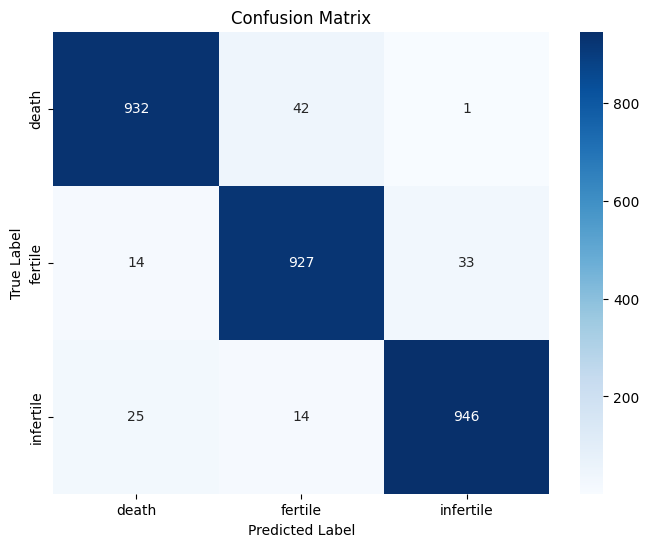

In [ ]:
#TEST DATA AND PREDICTIONS

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Créez un générateur de données pour les données de test
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Vous pouvez ajouter d'autres transformations si nécessaire

# Chemin vers le répertoire contenant les images de test
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/finalThesis/dataset'

# Chargez vos données de test et effectuez des prédictions avec le modèle
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),  # Taille d'image que vous avez utilisée pendant l'entraînement
    batch_size=8,
    class_mode='categorical',  # Pour obtenir les étiquettes directes
    shuffle=False  # Assurez-vous que les prédictions correspondent aux étiquettes dans le même ordre
)

# Chargez les données de test et effectuez des prédictions
test_generator.reset()
# Obtenez les vraies étiquettes à partir du DataFrame test
y_true = test_generator.classes  # Les vraies étiquettes
# Effectuez des prédictions avec le modèle
y_pred = model.predict(test_generator)

# Convertissez les prédictions en classes (étiquettes) réelles
y_pred_classes = np.argmax(y_pred, axis=1)

# Affichez le rapport de classification
class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

# Obtenez la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Définissez la liste des classes
classes = ['death', 'fertile', 'infertile']

# Affichez la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Epoch 1/20
367/367 [==============================] - 537s 1s/step - loss: 0.1744 - accuracy: 0.9404 - val_loss: 0.0968 - val_accuracy: 0.9639
Epoch 2/20
367/367 [==============================] - 600s 2s/step - loss: 0.1458 - accuracy: 0.9516 - val_loss: 0.0787 - val_accuracy: 0.9714
Epoch 3/20
367/367 [==============================] - 519s 1s/step - loss: 0.1522 - accuracy: 0.9465 - val_loss: 0.1126 - val_accuracy: 0.9632
Epoch 4/20
367/367 [==============================] - 501s 1s/step - loss: 0.1769 - accuracy: 0.9482 - val_loss: 0.1407 - val_accuracy: 0.9557
Epoch 5/20
367/367 [==============================] - 509s 1s/step - loss: 0.1439 - accuracy: 0.9499 - val_loss: 0.0901 - val_accuracy: 0.9710
Epoch 6/20
367/367 [==============================] - 510s 1s/step - loss: 0.1577 - accuracy: 0.9397 - val_loss: 0.0810 - val_accuracy: 0.9717
Epoch 7/20
367/367 [==============================] - 508s 1s/step - loss: 0.1467 - accuracy: 0.9479 - val_loss: 0.0774 - val_accuracy: 0.9741

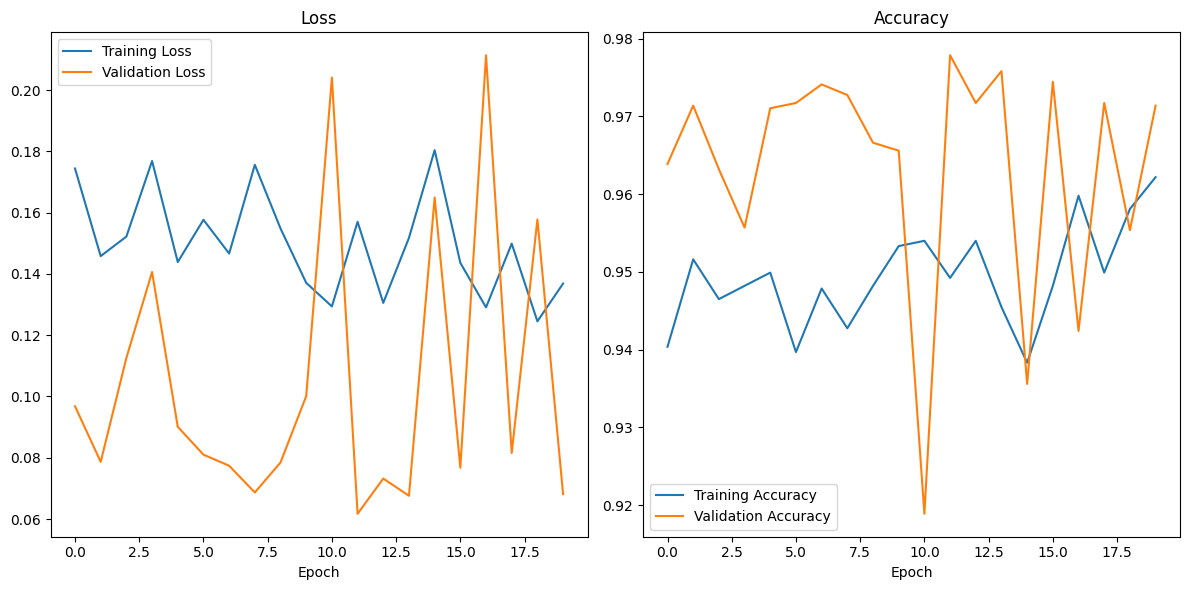

In [ ]:
# Entraînez le modèle en utilisant les générateurs de données
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)

# Affichez les courbes de perte et de précision
import matplotlib.pyplot as plt

# Courbe de perte
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'], loc='upper right')

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'], loc='lower right')

plt.tight_layout()
plt.show()


In [ ]:
#COMPUTE OTHER METRIX

from sklearn.metrics import confusion_matrix

# Obtenez la matrice de confusion
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Créez des variables pour stocker les résultats
vrais_positifs = []
faux_positifs = []
vrais_negatifs = []
faux_negatifs = []

# Itérez sur chaque classe
for i in range(len(cm)):
    vrais_positifs.append(cm[i, i])
    vrais_negatifs.append(sum(sum(cm)) - sum(cm[i, :]) - sum(cm[:, i]) + cm[i, i])
    faux_positifs.append(sum(cm[i, :]) - cm[i, i])
    faux_negatifs.append(sum(cm[:, i]) - cm[i, i])

# Maintenant, vous avez des listes pour chaque classe contenant les vrais positifs, les faux positifs, les vrais négatifs et les faux négatifs.

# Affichez les résultats pour chaque classe
for i in range(len(cm)):
    print(f'Class {i}:')
    print(f'True Positive: {vrais_positifs[i]}')
    print(f'False Positive: {faux_positifs[i]}')
    print(f'True Negative: {vrais_negatifs[i]}')
    print(f'False Negative: {faux_negatifs[i]}')


Class 0:
True Positive: 967
False Positive: 8
True Negative: 1913
False Negative: 46
Class 1:
True Positive: 896
False Positive: 78
True Negative: 1938
False Negative: 22
Class 2:
True Positive: 964
False Positive: 21
True Negative: 1910
False Negative: 39


In [ ]:
#SAVE MODEL

import joblib

# Enregistrez votre modèle à l'aide de joblib
joblib.dump(model, 'modele_egg_analysis.joblib')


['modele_egg_analysis.joblib']

In [ ]:
#CONVERSION DU MODEL EN FORMAT TFLite

import tensorflow as tf

# Convert Keras model into TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('modele_egg_analysis_2.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
#QUANTIFIER LE MODEL POUR REDUIRE LA TAILLE DU MODEL TFLITE

import tensorflow as tf

# Chargez le modèle TFLite
tflite_model_path = '/content/modele_egg_analysis_2.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Quantifiez le modèle
converter = tf.lite.TFLiteConverter.from_saved_model(tflite_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Enregistrez le modèle quantifié
with open('modele_quantifie.tflite', 'wb') as f:
    f.write(tflite_quantized_model)


OSError: ignored

In [ ]:
for filename in uploaded.keys():
    print(f'Fichier téléchargé : {filename}')

Fichier téléchargé : modele_egg_analysis_2.tflite


In [ ]:
import tensorflow as tf

# Charger le modèle TensorFlow Lite
model_path = list(uploaded.keys())[0]
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Obtenir les détails du modèle
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Vérifier si le modèle fonctionne correctement
print("Modèle chargé avec succès:", model_path)


Modèle chargé avec succès: modele_egg_analysis_2.tflite


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('chemin/vers/votre/model.h5')


In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
MODEL_TF = '/content/modele_egg_analysis_2.tflite'
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([train_generator[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)